In [2]:
!pip install pandas
!pip install numpy
!pip install gensim
!pip install spacy
!pip install -U accelerate
!pip install -U transformers

  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached numpy-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
Using cached pytz-2025.1-py2.py3-none-any.whl (507 kB)
Using cached tzdata-2025.1-py2.py3-none-any.whl (346 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached wrapt-1.17.2-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadat

In [2]:
import pandas as pd

# Author Recognition

## Import Data and clean data

In [25]:
PATH_TO_RAW_DATA = "../data/rick_and_morty_master.csv"
PATH_TO_CLEAN_DATA = r"../data/rick_and_morty_master_clean.csv"

df = pd.read_csv( PATH_TO_CLEAN_DATA , index_col = "Unnamed: 0")
df


,episode no.,speaker,dialouge
0,1,Rick,stumbl drunkenli turn light morty got tocom ju...
1,1,Morty,rub eye rick go
2,1,Rick,got surpris morty
3,1,Morty,middl night talk
4,1,Rick,spill alcohol morti bed come got surpris drags...
...,...,...,...
9613,51,Mr Poopybutthole,cuz want love thought felt becom
9614,51,Mr Poopybutthole,ever think horrifi peopl love would found tr...
9615,51,Mr Poopybutthole,wish
9616,51,Mr Poopybutthole,wish brave enough love back know mayb tri


In [6]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [22]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [26]:
# Clean Speaker and Text data
df["speaker"] = df["speaker"].astype("str")
df['speaker'] = df["speaker"].apply(lambda x : x.lower())
df["dialouge"] = df["dialouge"].str.replace("[^\w\s]","" , regex=True)
df["speaker"] = df["speaker"].str.replace("[^\w\s]","" , regex=True)

#double jerry beth and summer as they are underrepresanted
speakers = ["rick" , "morty" , "jerry" , "beth" , "summer"]
imb_speaker =  ["jerry" , "beth" , "summer"]
#
df = df[df.speaker.isin(speakers)]
# df = pd.concat([df ,df_imb_speaker])


#Encode speakers to numbers
labelencoder = LabelEncoder()
df['speaker_enc'] = labelencoder.fit_transform(df['speaker'].tolist())
print(df['speaker_enc'].value_counts())
print(df['speaker'].value_counts())

speaker_enc
3    2052
2    1531
1     816
0     685
4     651
Name: count, dtype: int64
speaker
rick      2052
morty     1531
jerry      816
beth       685
summer     651
Name: count, dtype: int64


/tmp/ipykernel_20865/3835786018.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speaker_enc'] = labelencoder.fit_transform(df['speaker'].tolist())


In [17]:
df['speaker'].value_counts()

speaker
rick      2052
jerry     1632
morty     1531
beth      1370
summer    1302
Name: count, dtype: int64

### Modeling

In [7]:
import torch
import numpy as np
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification

from torch.utils.data import Dataset
from transformers import AdamW, DataCollatorWithPadding
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from transformers import EvalPrediction


2025-03-11 22:10:23.799248: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 22:10:24.077857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741727424.194050  749796 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741727424.224312  749796 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 22:10:24.483673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [29]:
df_train, df_val = train_test_split(df,test_size=0.2, random_state=42)


imb_speaker =  ["jerry" , "beth" , "summer"]
df_imb_speaker = df_train[df_train.speaker.isin(imb_speaker)]
df_train = pd.concat([df_train ,df_imb_speaker])

train_labels = df_train["speaker_enc"].to_list()
val_labels = df_val["speaker_enc"].to_list()

train_texts = [ str(x).lower() for x in df_train['dialouge']]
val_texts = [ str(x).lower() for x in df_val['dialouge']]


1147

In [10]:
class Transcript_RM(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])
    
        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')
    
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }


In [27]:
# download tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# tokenize data
x_token_train = tokenizer(train_texts, truncation=True , padding=True , max_length=32)
x_token_test = tokenizer(val_texts, truncation=True , padding=True , max_length=32)
train_dataset = Transcript_RM(train_texts, train_labels , tokenizer )
val_dataset = Transcript_RM(val_texts, val_labels , tokenizer )

train_dataset

In [16]:

# Functions for calculating extra metriics while training
def single_label_metrics(predictions, labels):
    probs = torch.nn.Softmax(dim=1)(torch.Tensor(predictions)) 
    y_pred = torch.argmax(probs, dim=1).numpy()  
    y_true = labels

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, probs, multi_class='ovr')  

    metrics = {
        "accuracy": accuracy,
        "f1": f1,
        "roc_auc": roc_auc
    }

    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    return single_label_metrics(predictions=preds, labels=p.label_ids)


### Goodfit check

In [10]:
from transformers import TrainingArguments, Trainer

In [25]:
# Train 3 models (1,2,3,4,5) epochs and see test result
results = []
trainers = []
for x in range(8):
        
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
    
    # Define training arguments
    training_args = TrainingArguments(
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        output_dir = './results',
        num_train_epochs=x + 1,
        save_steps=1000,
        save_total_limit=2
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics = compute_metrics
    )
    
    # Train the model
    trainer.train()
    trainers.append(pd.DataFrame(trainer.state.log_history))
    # Evaluation
    eval_results = trainer.evaluate()
    results.append(eval_results)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_451235/925510396.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_451235/925510396.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_451235/925510396.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_451235/925510396.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_451235/925510396.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_451235/925510396.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.967800


/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_451235/925510396.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.949200


/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_451235/925510396.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.887700


/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [35]:
trainers[7]["train_loss"][0]

nan

### Plot Results

In [21]:
!pip install matplotlib

  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 13.7 MB/s eta 0:00:0000:0100:01
Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (323 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-many

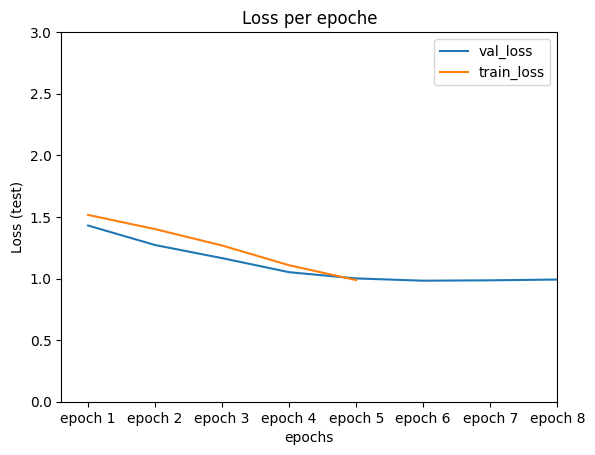

In [36]:
import matplotlib.pyplot as plt
losses = [d["eval_loss"] for d in results]
train_loss = [x["train_loss"][0] for x in trainers]

plt.plot(losses , label="val_loss")
plt.plot(train_loss , label="train_loss")
plt.ylim(0,3)
plt.xlim(-0.4,2.4)
plt.xticks(ticks=range(8), labels=["epoch 1" , "epoch 2" , "epoch 3" , "epoch 4" , "epoch 5", "epoch 6" , "epoch 7" , "epoch 8"])
plt.title("Loss per epoche")
plt.xlabel("epochs")
plt.ylabel("Loss (test)")
plt.legend()


Text(0, 0.5, 'F1 Score (test)')

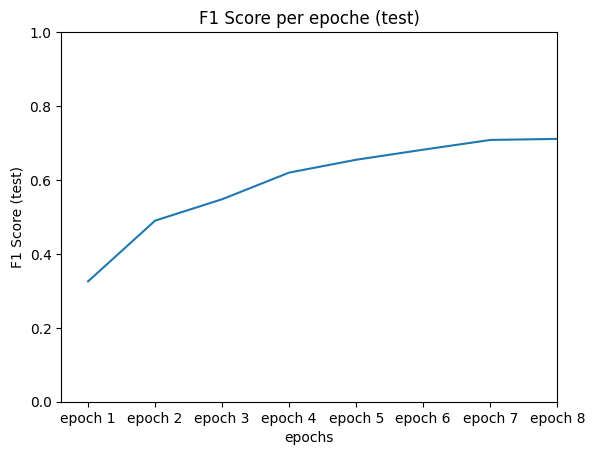

In [29]:
import matplotlib.pyplot as plt
losses = [d["eval_f1"] for d in results]

plt.plot(losses )
plt.ylim(0,1)
plt.xlim(-0.4,2.4)
plt.xticks(ticks=range(8), labels=["epoch 1" , "epoch 2" , "epoch 3" , "epoch 4" , "epoch 5", "epoch 6" , "epoch 7" , "epoch 8"])
plt.title("F1 Score per epoche (test)")
plt.xlabel("epochs")
plt.ylabel("F1 Score (test)")


In [285]:
from sklearn.model_selection import KFold

## Train Model

In [37]:

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=4,
    save_steps=1000,
    save_total_limit=2
)
# Prepare data collator for padding sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Define Trainer object for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
#    data_collator=data_collator,
    compute_metrics = compute_metrics
)

# Train the model
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_451235/1405658543.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=396, training_loss=1.1163032608802872, metrics={'train_runtime': 114.4994, 'train_samples_per_second': 220.403, 'train_steps_per_second': 3.459, 'total_flos': 835781530659840.0, 'train_loss': 1.1163032608802872, 'epoch': 4.0})

In [38]:
trainer.evaluate()

/home/geiger.a@ab.ba.ba-ravensburg.de/text_analysis/venv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 1.0696700811386108,
 'eval_accuracy': 0.6134347275031685,
 'eval_f1': 0.6097157514097489,
 'eval_roc_auc': 0.8544847706760368,
 'eval_runtime': 4.0858,
 'eval_samples_per_second': 386.215,
 'eval_steps_per_second': 6.119,
 'epoch': 4.0}

In [1]:
model_path = "./distilbert_finetuned"

# Modell und Tokenizer speichern
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

NameError: name 'model' is not defined

In [5]:
# Modell laden
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Tokenizer laden
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

In [41]:
val_labels

[3,
 1,
 3,
 4,
 2,
 0,
 3,
 3,
 4,
 0,
 4,
 3,
 1,
 3,
 2,
 2,
 0,
 2,
 1,
 4,
 4,
 2,
 1,
 2,
 1,
 2,
 3,
 0,
 2,
 1,
 4,
 0,
 3,
 1,
 1,
 1,
 0,
 1,
 3,
 3,
 3,
 3,
 0,
 3,
 1,
 3,
 3,
 1,
 2,
 1,
 0,
 4,
 3,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 3,
 3,
 0,
 2,
 1,
 0,
 0,
 4,
 4,
 0,
 3,
 4,
 1,
 3,
 1,
 3,
 3,
 4,
 2,
 3,
 4,
 1,
 0,
 3,
 3,
 3,
 4,
 3,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 3,
 0,
 3,
 0,
 0,
 3,
 1,
 3,
 3,
 3,
 0,
 3,
 3,
 1,
 4,
 3,
 3,
 3,
 0,
 2,
 1,
 3,
 1,
 4,
 3,
 4,
 0,
 3,
 4,
 1,
 1,
 2,
 4,
 0,
 4,
 4,
 4,
 1,
 0,
 2,
 0,
 1,
 3,
 4,
 0,
 3,
 4,
 2,
 3,
 4,
 3,
 1,
 0,
 3,
 2,
 2,
 1,
 2,
 3,
 1,
 3,
 2,
 2,
 2,
 3,
 4,
 1,
 3,
 2,
 0,
 4,
 3,
 1,
 1,
 2,
 4,
 4,
 1,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 4,
 2,
 3,
 2,
 2,
 3,
 0,
 4,
 4,
 1,
 4,
 3,
 1,
 2,
 1,
 3,
 3,
 1,
 3,
 1,
 0,
 2,
 1,
 4,
 4,
 3,
 0,
 4,
 1,
 3,
 0,
 3,
 4,
 1,
 1,
 2,
 3,
 1,
 2,
 3,
 1,
 0,
 3,
 0,
 3,
 3,
 0,
 1,
 2,
 2,
 4,
 0,
 0,
 3,
 0,
 3,
 2,
 2,
 2,
 4,
 3,
 3,
 1,
 3,
 4,
 1,
 2,
 1,
 3,
 0,


In [30]:
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    save_steps=1000,
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics
)

/tmp/ipykernel_555713/3202834840.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
def get_prediction(input_str : str):
    encoding = tokenizer(input_str, return_tensors='pt')
    encoding.to(trainer.model.device)
    
    outputs = trainer.model(**encoding)
    outputs["logits"].sort(descending=True)
    print(outputs["logits"].sort(descending=True))
    pred_speaker = labelencoder.classes_[int(outputs["logits"].sort(descending=True)[1][0][0])]
    return str(pred_speaker)

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    return single_label_metrics(predictions=preds, labels=p.label_ids)

In [31]:
get_prediction("The weather is good")

torch.return_types.sort(
values=tensor([[ 0.3029,  0.2077, -0.0460, -0.6124, -0.6613]], device='cuda:0',
       grad_fn=<SortBackward0>),
indices=tensor([[0, 4, 1, 3, 2]], device='cuda:0'))


'beth'

In [8]:
labelencoder.classes_

NameError: name 'labelencoder' is not defined

### print Consufion Matrix

In [32]:
def get_prediction_cm(input_str : str):
    encoding = tokenizer(input_str, return_tensors='pt')
    encoding.to(trainer.model.device)
    
    outputs = trainer.model(**encoding)
    outputs["logits"].sort(descending=True)
    print(outputs["logits"].sort(descending=True))
    speaker_num = int(outputs["logits"].sort(descending=True)[1][0][0])
    return speaker_num

In [33]:
predictions_cm : list[str] = []
for i in range(len(val_labels)):
    predictions_cm.append(get_prediction_cm(val_texts[i]))

predictions_cm
    

torch.return_types.sort(
values=tensor([[ 2.3131,  0.9633, -0.8209, -1.9870, -2.2160]], device='cuda:0',
       grad_fn=<SortBackward0>),
indices=tensor([[3, 1, 2, 4, 0]], device='cuda:0'))
torch.return_types.sort(
values=tensor([[ 1.3402,  1.1879, -0.1963, -0.7281, -2.5755]], device='cuda:0',
       grad_fn=<SortBackward0>),
indices=tensor([[3, 2, 1, 4, 0]], device='cuda:0'))
torch.return_types.sort(
values=tensor([[ 2.7101, -0.4432, -0.6823, -1.7316, -1.7766]], device='cuda:0',
       grad_fn=<SortBackward0>),
indices=tensor([[3, 2, 1, 0, 4]], device='cuda:0'))
torch.return_types.sort(
values=tensor([[ 1.1026,  0.9851, -0.7851, -0.8033, -1.1261]], device='cuda:0',
       grad_fn=<SortBackward0>),
indices=tensor([[0, 4, 1, 3, 2]], device='cuda:0'))
torch.return_types.sort(
values=tensor([[ 0.3695,  0.1340,  0.0159, -0.0885, -0.5691]], device='cuda:0',
       grad_fn=<SortBackward0>),
indices=tensor([[4, 2, 1, 0, 3]], device='cuda:0'))
torch.return_types.sort(
values=tensor([[ 1.7606, 

[3,
 3,
 3,
 0,
 4,
 0,
 3,
 3,
 4,
 0,
 4,
 3,
 1,
 3,
 2,
 0,
 0,
 3,
 3,
 4,
 4,
 2,
 1,
 2,
 1,
 1,
 3,
 0,
 2,
 1,
 4,
 0,
 3,
 1,
 1,
 3,
 0,
 1,
 1,
 3,
 3,
 3,
 4,
 4,
 1,
 3,
 2,
 1,
 2,
 2,
 4,
 1,
 4,
 0,
 1,
 4,
 0,
 0,
 0,
 1,
 2,
 1,
 0,
 3,
 3,
 2,
 0,
 4,
 4,
 4,
 4,
 0,
 1,
 3,
 1,
 4,
 4,
 0,
 3,
 3,
 4,
 1,
 0,
 4,
 3,
 3,
 4,
 3,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 3,
 0,
 3,
 4,
 0,
 3,
 2,
 3,
 3,
 2,
 0,
 3,
 1,
 2,
 4,
 2,
 3,
 3,
 0,
 4,
 1,
 3,
 1,
 4,
 3,
 4,
 0,
 2,
 0,
 1,
 1,
 4,
 4,
 4,
 4,
 1,
 4,
 1,
 1,
 2,
 0,
 1,
 3,
 3,
 2,
 2,
 4,
 2,
 1,
 3,
 3,
 0,
 0,
 2,
 3,
 3,
 1,
 2,
 3,
 1,
 0,
 4,
 2,
 3,
 1,
 4,
 1,
 3,
 2,
 0,
 4,
 1,
 2,
 4,
 2,
 4,
 4,
 1,
 2,
 2,
 4,
 3,
 3,
 3,
 2,
 4,
 2,
 3,
 3,
 2,
 3,
 0,
 4,
 2,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 0,
 4,
 1,
 4,
 0,
 3,
 2,
 4,
 1,
 1,
 2,
 3,
 4,
 1,
 1,
 2,
 4,
 2,
 3,
 0,
 1,
 0,
 3,
 0,
 2,
 3,
 0,
 1,
 0,
 2,
 4,
 3,
 1,
 3,
 1,
 2,
 4,
 2,
 2,
 4,
 1,
 4,
 1,
 0,
 2,
 1,
 2,
 1,
 2,
 0,


In [52]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


              precision    recall  f1-score   support

        beth       0.64      0.71      0.67       245
       jerry       0.65      0.67      0.66       319
       morty       0.57      0.50      0.53       320
        rick       0.70      0.62      0.66       438
      summer       0.48      0.57      0.52       256

    accuracy                           0.61      1578
   macro avg       0.61      0.62      0.61      1578
weighted avg       0.62      0.61      0.61      1578



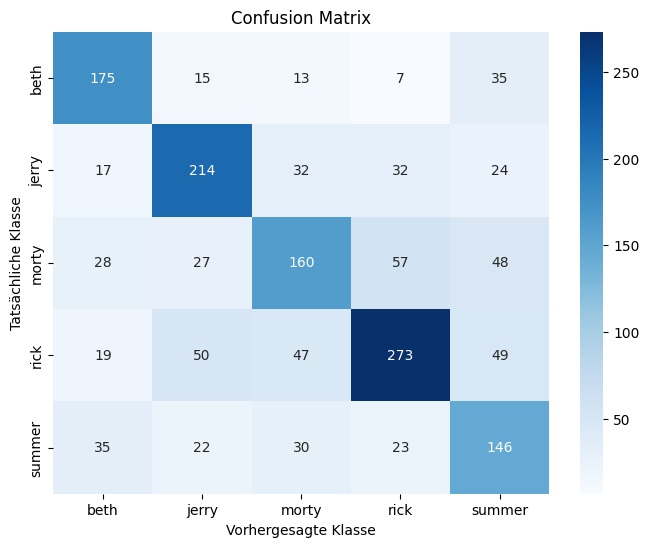

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Erstellt eine mehrklassige Confusion Matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Vorhergesagte Klasse")
    plt.ylabel("Tatsächliche Klasse")
    plt.title("Confusion Matrix")
    plt.show()

y_true = val_labels  # Tatsächliche Klassen
y_pred = predictions_cm # Vorhergesagte Klassen
class_names = labelencoder.classes_

print(classification_report(y_true, y_pred, target_names=class_names))
plot_confusion_matrix(y_true, y_pred, class_names)


In [37]:
!pip install tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.70.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached h5py-3.13.0-cp312-cp312-manylinux_2_17_x86_64.ma

In [55]:
import tensorflow as tf
text = "earth is a planet"

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

outputs["logits"].sort(descending=True)
print(outputs["logits"].sort(descending=True)[0][0])
#print(np.array(outputs["logits"].detach().cpu().numpy()))
print(tf.nn.softmax(outputs["logits"].detach().cpu().numpy()))
pred_speaker = labelencoder.classes_[int(outputs["logits"].sort(descending=True)[1][0][0])]
pred_speaker

tensor([ 0.9754, -0.0065, -0.0587, -0.8011, -0.8221], device='cuda:0',
       grad_fn=<SelectBackward0>)
tf.Tensor([[0.08024344 0.48425457 0.17216632 0.18139054 0.0819452 ]], shape=(1, 5), dtype=float32)


'jerry'

In [384]:
labelencoder.classes_

array(['beth', 'jerry', 'morty', 'rick', 'summer'], dtype='<U6')

In [385]:
trainer.evaluate()

{'eval_loss': 1.0054600238800049,
 'eval_accuracy': 0.6520912547528517,
 'eval_f1': 0.6556604611116008,
 'eval_roc_auc': 0.8843104383955385,
 'eval_runtime': 10.6996,
 'eval_samples_per_second': 147.483,
 'eval_steps_per_second': 18.505,
 'epoch': 3.0}